In [1]:
#@title Run to install MuJoCo and `dm_control`
import distutils.util
import subprocess
if subprocess.run('nvidia-smi').returncode:
  raise RuntimeError(
      'Cannot communicate with GPU. '
      'Make sure you are using a GPU Colab runtime. '
      'Go to the Runtime menu and select Choose runtime type.')

print('Installing dm_control...')
!pip install "dm_control>=1.0.2"

# Configure dm_control to use the EGL rendering backend (requires GPU)
%env MUJOCO_GL=osmesa

print('Checking that the dm_control installation succeeded...')
try:
  from dm_control import suite
  env = suite.load('cartpole', 'swingup')
  pixels = env.physics.render()
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".')
else:
  del suite, pixels
print('dm_control installation succeeded.')

Mon May 23 15:06:39 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.68.02    Driver Version: 512.77       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0  On |                  N/A |
| 30%   50C    P0    90W / 320W |    826MiB / 10240MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 패키지 사용을 위한 Imports들

In [5]:
#@title All `dm_control` imports required for this tutorial

# The basic mujoco wrapper.
from dm_control import mujoco

# Access to enums and MuJoCo library functions.
from dm_control.mujoco.wrapper.mjbindings import enums
from dm_control.mujoco.wrapper.mjbindings import mjlib

# Composer high level imports
from dm_control import composer
from dm_control.composer.observation import observable
from dm_control.composer import variation

# Imports for Composer tutorial example
from dm_control.composer.variation import distributions
from dm_control.composer.variation import noises
from dm_control.locomotion.arenas import floors

# Control Suite
from dm_control import suite

# Run through corridor example
from dm_control.locomotion.walkers import cmu_humanoid
from dm_control.locomotion.arenas import corridors as corridor_arenas
from dm_control.locomotion.tasks import corridors as corridor_tasks

# Soccer
from dm_control.locomotion import soccer

# Manipulation
from dm_control import manipulation

In [6]:
#@title Other imports and helper functions

# General
import copy
import os
import time
import itertools
from IPython.display import clear_output
import numpy as np

# Graphics-related
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from IPython.display import HTML
import PIL.Image
# Internal loading of video libraries.

# Use svg backend for figure rendering
%config InlineBackend.figure_format = 'svg'

# Font sizes
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Inline video helper function
if os.environ.get('COLAB_NOTEBOOK_TEST', False):
  # We skip video generation during tests, as it is quite expensive.
  display_video = lambda *args, **kwargs: None
else:
  def display_video(frames, framerate=30):
    height, width, _ = frames[0].shape
    dpi = 70
    orig_backend = matplotlib.get_backend()
    matplotlib.use('Agg')  # Switch to headless 'Agg' to inhibit figure rendering.
    fig, ax = plt.subplots(1, 1, figsize=(width / dpi, height / dpi), dpi=dpi)
    matplotlib.use(orig_backend)  # Switch back to the original backend.
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.set_position([0, 0, 1, 1])
    im = ax.imshow(frames[0])
    def update(frame):
      im.set_data(frame)
      return [im]
    interval = 1000/framerate
    anim = animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                   interval=interval, blit=True, repeat=False)
    return HTML(anim.to_html5_video())

# Seed numpy's global RNG so that cell outputs are deterministic. We also try to
# use RandomState instances that are local to a single cell wherever possible.
np.random.seed(42)

## 모델 정의, 모델 조합 그리고 렌더링 과정

### 정적 모델의 정의와 확인 과정

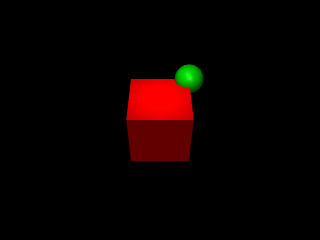

In [7]:
# #@title A static model {vertical-output: true}

# static_model = """
# <mujoco>
#   <worldbody>
#     <light name="top" pos="0 0 1"/>
#     <geom name="red_box" type="box" size=".2 .2 .2" rgba="1 0 0 1"/>
#     <geom name="green_sphere" pos=".2 .2 .2" size=".1" rgba="0 1 0 1"/>
#   </worldbody>
# </mujoco>
# """
# physics = mujoco.Physics.from_xml_string(static_model)
# pixels = physics.render()
# PIL.Image.fromarray(pixels)

뱀 로봇 정의 파일

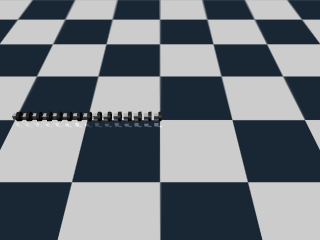

In [10]:
static_model = """

<!-- © 2021 Bongsub Song <doorebong@gmail.com> -->
 <!-- All right reserved -->
 <!-- Description : BRM snake robot Mujoco simulation xml -->

<mujoco model="snake-dgist">

    <compiler inertiafromgeom="true" angle="degree" convexhull="false"/>

    <option timestep="0.01" iterations="50" tolerance="1e-10" solver="Newton" jacobian="dense" cone="elliptic"/>
    <!-- <option timestep="0.001" iterations="50" tolerance="1e-10" solver="Newton" jacobian="dense" cone="pyramidal"/> -->

    <!-- <size nconmax="5000" njmax="20000" nstack="50000"/> -->
     <size nconmax="5000" njmax="2000" nstack="50000"/>

    <visual>
        <map force="0.1" zfar="30"/>
        <rgba haze="0.15 0.25 0.35 1"/>
        <quality shadowsize="2048"/>
        <global offwidth="800" offheight="800"/>
    </visual>

    <asset>
        <texture type="skybox" builtin="gradient" rgb1="0.5 0.7 0.9" rgb2="0.1 0.1 0.1" width="512" height="512"/> 

        <texture name="texplane" type="2d" builtin="checker" rgb1=".8 .8 .8" rgb2=".1 0.15 0.2" width="512" height="512" mark="cross" markrgb=".8 .8 .8"/>  

        <texture name="texgeom" type="cube" builtin="flat" mark="cross" width="127" height="1278" 
            rgb1="0.8 0.6 0.4" rgb2="0.8 0.6 0.4" markrgb="1 1 1" random="0.01"/>  

        <material name="matplane" reflectance="0.3" texture="texplane" texrepeat="2 2" texuniform="true"/>

        <material name="matgeom" texture="texgeom" texuniform="true" rgba="0.8 0.6 .4 1"/>

    </asset>

    <worldbody>

        <geom name="floor" pos="0 0 0" size="0 0 .25" type="plane" material="matplane" condim="3" friction="0.55 0.01 0.01"/>

        <light directional="false" diffuse="1 1 1" specular="0 0 0" pos="0 0 15" dir="0 0 -1" castshadow="false"/>

    <!-- Snake -->
        <body name="head" pos="0 0 0.033" euler="0 -90 0"> <!--홀-->
            <freejoint name="root"/>    
            <geom type="cylinder" size="0.0325 0.01" rgba="0.1 0.1 0.1 1" mass="0.04" condim="6" friction="0.55 0.01 0.01"/>
            <geom type="box" size="0.017 0.01425 0.02525" pos="0 0 0.01525" mass="0.1"/>

            <body name="link1" pos="0 0 0.0685"> <!--짝-->
                <joint name="joint1" type="hinge" pos="0 0 -0.02925" axis="0 1 0" limited="true" range="-90 90" damping="0.6" armature="0.01" />
                <geom type="cylinder" size="0.0325 0.01" rgba="0.1 0.1 0.1 1" mass="0.04" condim="6" friction="0.55 0.01 0.01"/>
                <geom type="box" size="0.01425 0.017 0.02525" pos="0 0 0.01525" mass="0.1"/>

                <body name="link2" pos="0 0 0.0685"> <!--홀-->
                    <joint name="joint2" type="hinge" pos="0 0 -0.02925" axis="1 0 0" limited="true" range="-90 90" damping="0.6" armature="0.01" />
                    <geom type="cylinder" size="0.0325 0.01" rgba="0.1 0.1 0.1 1" mass="0.04" condim="6" friction="0.55 0.01 0.01"/>
                    <geom type="box" size="0.017 0.01425 0.02525" pos="0 0 0.01525" mass="0.1"/>

                    <body name="link3" pos="0 0 0.0685"> <!--짝-->
                        <joint name="joint3" type="hinge" pos="0 0 -0.02925" axis="0 1 0" limited="true" range="-90 90" damping="0.6" armature="0.01" />
                        <geom type="cylinder" size="0.0325 0.01" rgba="0.1 0.1 0.1 1" mass="0.04" condim="6" friction="0.55 0.01 0.01"/>
                        <geom type="box" size="0.01425 0.017 0.02525" pos="0 0 0.01525" mass="0.1"/>

                        <body name="link4" pos="0 0 0.0685"> <!--홀-->
                            <joint name="joint4" type="hinge" pos="0 0 -0.02925" axis="1 0 0" limited="true" range="-90 90" damping="0.6" armature="0.01" />
                            <geom type="cylinder" size="0.0325 0.01" rgba="0.1 0.1 0.1 1" mass="0.04" condim="6" friction="0.55 0.01 0.01"/>
                            <geom type="box" size="0.017 0.01425 0.02525" pos="0 0 0.01525" mass="0.1"/>

                            <body name="link5" pos="0 0 0.0685"> <!--짝-->
                                <joint name="joint5" type="hinge" pos="0 0 -0.02925" axis="0 1 0" limited="true" range="-90 90" damping="0.6" armature="0.01" />
                                <geom type="cylinder" size="0.0325 0.01" rgba="0.1 0.1 0.1 1" mass="0.04" condim="6" friction="0.55 0.01 0.01"/>
                                <geom type="box" size="0.01425 0.017 0.02525" pos="0 0 0.01525" mass="0.1"/>

                                <body name="link6" pos="0 0 0.0685"> <!--홀-->
                                    <joint name="joint6" type="hinge" pos="0 0 -0.02925" axis="1 0 0" limited="true" range="-90 90" damping="0.6" armature="0.01" />
                                    <geom type="cylinder" size="0.0325 0.01" rgba="0.1 0.1 0.1 1" mass="0.04" condim="6" friction="0.55 0.01 0.01"/>
                                    <geom type="box" size="0.017 0.01425 0.02525" pos="0 0 0.01525" mass="0.1"/>

                                    <body name="link7" pos="0 0 0.0685"> <!--짝-->
                                        <joint name="joint7" type="hinge" pos="0 0 -0.02925" axis="0 1 0" limited="true" range="-90 90" damping="0.6" armature="0.01" />
                                        <geom type="cylinder" size="0.0325 0.01" rgba="0.1 0.1 0.1 1" mass="0.04" condim="6" friction="0.55 0.01 0.01"/>
                                        <geom type="box" size="0.01425 0.017 0.02525" pos="0 0 0.01525" mass="0.1"/>

                                        <body name="link8" pos="0 0 0.0685"> <!--홀-->
                                            <joint name="joint8" type="hinge" pos="0 0 -0.02925" axis="1 0 0" limited="true" range="-90 90" damping="0.6" armature="0.01" />
                                            <geom type="cylinder" size="0.0325 0.01" rgba="0.1 0.1 0.1 1" mass="0.04" condim="6" friction="0.55 0.01 0.01"/>
                                            <geom type="box" size="0.017 0.01425 0.02525" pos="0 0 0.01525" mass="0.1"/>

                                            <body name="link9" pos="0 0 0.0685"> <!--짝-->
                                                <joint name="joint9" type="hinge" pos="0 0 -0.02925" axis="0 1 0" limited="true" range="-90 90" damping="0.6" armature="0.01" />
                                                <geom type="cylinder" size="0.0325 0.01" rgba="0.1 0.1 0.1 1" mass="0.04" condim="6" friction="0.55 0.01 0.01"/>
                                                <geom type="box" size="0.01425 0.017 0.02525" pos="0 0 0.01525" mass="0.1"/>

                                                <body name="link10" pos="0 0 0.0685"> <!--홀-->
                                                    <joint name="joint10" type="hinge" pos="0 0 -0.02925" axis="1 0 0" limited="true" range="-90 90" damping="0.6" armature="0.01" />
                                                    <geom type="cylinder" size="0.0325 0.01" rgba="0.1 0.1 0.1 1" mass="0.04" condim="6" friction="0.55 0.01 0.01"/>
                                                    <geom type="box" size="0.017 0.01425 0.02525" pos="0 0 0.01525" mass="0.1"/>

                                                    <body name="link11" pos="0 0 0.0685"> <!--짝-->
                                                        <joint name="joint11" type="hinge" pos="0 0 -0.02925" axis="0 1 0" limited="true" range="-90 90" damping="0.6" armature="0.01" />
                                                        <geom type="cylinder" size="0.0325 0.01" rgba="0.1 0.1 0.1 1" mass="0.04" condim="6" friction="0.55 0.01 0.01"/>
                                                        <geom type="box" size="0.01425 0.017 0.02525" pos="0 0 0.01525" mass="0.1"/>

                                                        <body name="link12" pos="0 0 0.0685"> <!--홀-->
                                                            <joint name="joint12" type="hinge" pos="0 0 -0.02925" axis="1 0 0" limited="true" range="-90 90" damping="0.6" armature="0.01" />
                                                            <geom type="cylinder" size="0.0325 0.01" rgba="0.1 0.1 0.1 1" mass="0.04" condim="6" friction="0.55 0.01 0.01"/>
                                                            <geom type="box" size="0.017 0.01425 0.02525" pos="0 0 0.01525" mass="0.1"/>

                                                            <body name="link13" pos="0 0 0.0685"> <!--짝-->
                                                                <joint name="joint13" type="hinge" pos="0 0 -0.02925" axis="0 1 0" limited="true" range="-90 90" damping="0.6" armature="0.01" />
                                                                <geom type="cylinder" size="0.0325 0.01" rgba="0.1 0.1 0.1 1" mass="0.04" condim="6" friction="0.55 0.01 0.01"/>
                                                                <geom type="box" size="0.01425 0.017 0.02525" pos="0 0 0.01525" mass="0.1"/>

                                                                <body name="tail" pos="0 0 0.0685"> <!--홀-->
                                                                    <joint name="joint14" type="hinge" pos="0 0 -0.02925" axis="1 0 0" limited="true" range="-90 90" damping="0.6" armature="0.01" />
                                                                    <geom type="cylinder" size="0.0325 0.01" rgba="0.1 0.1 0.1 1" mass="0.04" condim="6" friction="0.55 0.01 0.01"/>
                                                                    <geom type="box" size="0.017 0.01425 0.02525" pos="0 0 0.01525" mass="0.1"/>
                                                                </body>
                                                            </body>
                                                        </body>
                                                    </body>
                                                </body>
                                            </body>
                                        </body>
                                    </body>
                                </body>
                            </body>
                        </body>
                    </body>
                </body>
            </body>
        </body>
    </worldbody>

    <actuator>
        <position name="servo_1" ctrllimited="true" ctrlrange="-1.5708 1.5708" forcelimited="true" forcerange="-3.0 3.0" gear="1" joint="joint1" kp="70"/>
        <position name="servo_2" ctrllimited="true" ctrlrange="-1.5708 1.5708" forcelimited="true" forcerange="-3.0 3.0" gear="1" joint="joint2" kp="70"/>
        <position name="servo_3" ctrllimited="true" ctrlrange="-1.5708 1.5708" forcelimited="true" forcerange="-3.0 3.0" gear="1" joint="joint3" kp="70"/>
        <position name="servo_4" ctrllimited="true" ctrlrange="-1.5708 1.5708" forcelimited="true" forcerange="-3.0 3.0" gear="1" joint="joint4" kp="70"/>
        <position name="servo_5" ctrllimited="true" ctrlrange="-1.5708 1.5708" forcelimited="true" forcerange="-3.0 3.0" gear="1" joint="joint5" kp="70"/>
        <position name="servo_6" ctrllimited="true" ctrlrange="-1.5708 1.5708" forcelimited="true" forcerange="-3.0 3.0" gear="1" joint="joint6" kp="70"/>
        <position name="servo_7" ctrllimited="true" ctrlrange="-1.5708 1.5708" forcelimited="true" forcerange="-3.0 3.0" gear="1" joint="joint7" kp="70"/>
        <position name="servo_8" ctrllimited="true" ctrlrange="-1.5708 1.5708" forcelimited="true" forcerange="-3.0 3.0" gear="1" joint="joint8" kp="70"/>
        <position name="servo_9" ctrllimited="true" ctrlrange="-1.5708 1.5708" forcelimited="true" forcerange="-3.0 3.0" gear="1" joint="joint9" kp="70"/>
        <position name="servo_10" ctrllimited="true" ctrlrange="-1.5708 1.5708" forcelimited="true" forcerange="-3.0 3.0" gear="1" joint="joint10" kp="70"/>
        <position name="servo_11" ctrllimited="true" ctrlrange="-1.5708 1.5708" forcelimited="true" forcerange="-3.0 3.0" gear="1" joint="joint11" kp="70"/>
        <position name="servo_12" ctrllimited="true" ctrlrange="-1.5708 1.5708" forcelimited="true" forcerange="-3.0 3.0" gear="1" joint="joint12" kp="70"/>
        <position name="servo_13" ctrllimited="true" ctrlrange="-1.5708 1.5708" forcelimited="true" forcerange="-3.0 3.0" gear="1" joint="joint13" kp="70"/>
        <position name="servo_14" ctrllimited="true" ctrlrange="-1.5708 1.5708" forcelimited="true" forcerange="-3.0 3.0" gear="1" joint="joint14" kp="70"/>
    </actuator>
</mujoco>

"""

physics = mujoco.Physics.from_xml_string(static_model)
pixels = physics.render()
PIL.Image.fromarray(pixels)

### 모델에 자유도 추가와 렌더링 과정

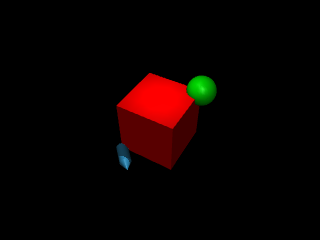

In [12]:
#@title A child body with a joint { vertical-output: true }

swinging_body = """
<mujoco>
  <worldbody>
    <light name="top" pos="0 0 1"/>
    <body name="box_and_sphere" euler="0 0 -30">  
      <joint name="swing" type="hinge" axis="1 -1 0" pos="-.2 -.2 -.2"/>
      <geom name="red_box" type="box" size=".2 .2 .2" rgba="1 0 0 1"/>
      <geom name="green_sphere" pos=".2 .2 .2" size=".1" rgba="0 1 0 1"/>
    </body>
  </worldbody>
</mujoco>
"""
physics = mujoco.Physics.from_xml_string(swinging_body)
# Visualize the joint axis.
scene_option = mujoco.wrapper.core.MjvOption()
scene_option.flags[enums.mjtVisFlag.mjVIS_JOINT] = True
pixels = physics.render(scene_option=scene_option)
PIL.Image.fromarray(pixels)

렌더링 시작!

In [13]:
#@title Making a video {vertical-output: true}

duration = 20    # (seconds)
framerate = 30  # (Hz)

# Visualize the joint axis
scene_option = mujoco.wrapper.core.MjvOption()
scene_option.flags[enums.mjtVisFlag.mjVIS_JOINT] = True

# Simulate and display video.
frames = []
physics.reset()  # Reset state and time
while physics.data.time < duration:
  physics.step()
  if len(frames) < physics.data.time * framerate:
    pixels = physics.render(scene_option=scene_option)
    frames.append(pixels)
display_video(frames, framerate)